In [6]:
import os
import sys
sys.path.append('./src') 
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser

from torch import nn
import torch
from torchdiffeq import odeint

In [30]:
dataset = "mvtec_ad"
category = "zipper"
num_inference_steps = 1000
device = 'cuda'
num_samples = 1
start_step = 64

In [31]:
from torch.utils.data import DataLoader
import torch

img_size = 256

normal_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    normal_only = True
)
anom_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    anom_only = True
)
train_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=True,
    img_size=img_size,
    transform_type="default",
    category = category,
)
print(len(normal_dataset))
print(len(anom_dataset))

32
119


In [32]:
# log_dir = f"./results/ad_unet_vae_ddad/{category}"
log_dir = f"./results/exp_unet_feature_ad_256/{category}"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_ema_latest.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

mim_in_sh = (272, 16, 16)

img_size = config['data']['img_size']
model: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
results = model.load_state_dict(model_ckpt, strict=False)
print(results)
model.to(device).eval()

_IncompatibleKeys(missing_keys=['net.label_emb.weight'], unexpected_keys=[])


Denoiser(
  (cls_embed): Embedding(15, 256)
  (net): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (label_emb): Embedding(15, 1024)
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(272, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=1024, out_features=256, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 25

In [33]:
model_kwargs = {
    'model_type': 'efficientnet-b4',
    'outblocks': (1, 5, 9, 21),
    'outstrides': (2, 4, 8, 16),
    'pretrained': True,
    'stride': 16
}
print(f"Using feature space reconstruction with {model_kwargs['model_type']} backbone")
feature_extractor = get_backbone(**model_kwargs)
feature_extractor.to(device).eval()

Using feature space reconstruction with efficientnet-b4 backbone


BackboneWrapper(
  (backbone): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSame

In [34]:
bs = 8
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=False)
normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

start_t = torch.tensor([0] * bs, device=device, dtype=torch.long)
end_t = torch.tensor([num_inference_steps] * bs, device=device, dtype=torch.long)

In [35]:
# Compute global stats for training data
features = []
for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    img = data["samples"].to(device)
    with torch.no_grad():
        x, _ = feature_extractor(img)
        features.append(x)
features = torch.cat(features, dim=0)   # (N, c, h, w)
avg_glo = features.mean(dim=(0, 2, 3))  # (c, )
std_glo = features.std(dim=(0, 2, 3))  # (c, )

100%|██████████| 30/30 [00:01<00:00, 22.76it/s]


In [36]:
print(f"Length of anom dataloader: {len(anom_dataloader)}")
print(f"Length of normal dataloader: {len(normal_dataloader)}")

Length of anom dataloader: 15
Length of normal dataloader: 4


In [37]:
# sample_batch = list(iter(anom_dataloader))[0]
sample_batch = list(iter(normal_dataloader))[0]
# sample_batch = next(iter(train_loader))
sample_imgs = sample_batch['samples'].to(device)
sample_labels = sample_batch['clslabels'].to(device)

with torch.no_grad():
    features, _ = feature_extractor(sample_imgs)
    features_normed = (features - avg_glo[None, :, None, None]) / std_glo[None, :, None, None]

In [38]:
sd = model.sample_diffusion
sd.num_timesteps

1000

In [39]:
import torch
import torch.nn as nn

class DDIMODEFunc(nn.Module):
    def __init__(self, model: Denoiser):
        super().__init__()
        self.model = model
        self.beta_min_t = torch.tensor(0.0001, dtype=torch.float32)
        self.beta_max_t = torch.tensor(0.02,    dtype=torch.float32)
        
        self.num_total_steps = model.train_diffusion.num_timesteps
        self.call_count = 0

    def _check_t(self, t):
        assert t >= 0 and t <= 1, f"t must be in [0, 1], got {t}"

    def beta(self, t):
        """
        beta(t) = (sqrt(beta_min) + t*(sqrt(beta_max)-sqrt(beta_min)))^2
        """
        self._check_t(t)
        t_t = torch.tensor(float(t), dtype=torch.float32)
        
        a = torch.sqrt(self.beta_min_t)  # a = sqrt(beta_min)
        b = torch.sqrt(self.beta_max_t)  # b = sqrt(beta_max)
        return (a + t_t * (b - a)) ** 2

    def _F(self, u: torch.Tensor) -> torch.Tensor:
        return (
            u * torch.log(1 - u**2)
            + torch.log((1 + u) / (1 - u))
            - 2.0 * u
        )

    def alpha(self, t):
        """
        alpha(t) = exp( (F(up) - F(a)) / (b-a) )
        where up = a + t*(b-a), a = sqrt(beta_min), b = sqrt(beta_max).
        """
        self._check_t(t)
        t_t = torch.tensor(float(t), dtype=torch.float32)
        
        a = torch.sqrt(self.beta_min_t)
        b = torch.sqrt(self.beta_max_t)
        
        up = a + (b - a) * t_t
        val = (self._F(up) - self._F(a)) / (b - a)
        return torch.exp(val)

    def scale_x(self, x, t):
        """
        scale_x(x, t) = x / sqrt(alpha(t))
        """
        self._check_t(t)
        alpha_t = self.alpha(t)
        return x / torch.sqrt(alpha_t)

    def rescale_x(self, x_bar, t):
        """
        rescale_x(x_bar, t) = x_bar * sqrt(alpha(t))
        """
        self._check_t(t)
        alpha_t = self.alpha(t)
        return x_bar * torch.sqrt(alpha_t)

    def sigma(self, t):
        """
        sigma(t) = sqrt((1 - alpha(t)) / alpha(t))
        """
        self._check_t(t)
        alpha_t = self.alpha(t)
        return torch.sqrt((1.0 - alpha_t) / alpha_t)

    def dsigma(self, t):
        self._check_t(t)
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return -0.5 * (torch.log(1 - beta_t)) / (alpha_t ** 0.5 * torch.sqrt(1 - alpha_t))

    def t_to_i(self, t, bshape):
        i = t * self.num_total_steps
        return i * torch.ones(bshape[0], device=t.device, dtype=torch.float32)
    
    def count_reset(self):
        self.call_count = 0

    @torch.no_grad()
    def forward(self, t, x, labels):
        self.call_count += 1
        s = self.sigma(t)
        ds = self.dsigma(t)
        
        x = x / torch.sqrt(1.0 + s**2)

        # cls_embed = self.model.cls_embed(labels)
        model_kwargs = {
            "c": labels,
        }
        eps = self.model.net(x, self.t_to_i(t, x.shape), **model_kwargs)
        return eps * ds

    
ode_func = DDIMODEFunc(model)

In [40]:

def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

def calculate_anomaly_ll(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=1)  # (bs, h, w)
    mp = torch.nn.functional.max_pool2d(ll, kernel_size=16, stride=16)  # (bs, 1, 1)
    mp = mp.squeeze(-1).squeeze(-1)  # (bs, )
    return mp

In [41]:
# x_init = features_normed
# start_eps = 1e-5
# x_init_bar = ode_func.scale_x(x_init, start_eps)

# t_eval = torch.linspace(start_eps, 1 - start_eps, 100, device=device)
# x_t_bar = odeint(lambda t, x: ode_func(t, x, sample_labels), x_init_bar, t_eval, method='euler')

# print(f"Number of Foward Evaluations: {ode_func.call_count}")
# ode_func.count_reset()

# # nan 
# if torch.isnan(x_t_bar).any():
#     print("nan detected")
#     print(x_t_bar)
#     print(torch.isnan(x_t_bar).any())
#     print(torch.isnan(x_t_bar).sum())

# # rescale
# x_t = ode_func.rescale_x(x_t_bar, t_eval[-1])

# x_T = x_t[-1]
# ll = calculate_log_pdf(x_T)

In [43]:
### Evaluation settings
solver = "euler"
start_eps = 1e-7
num_steps = 100
# t_eval = torch.linspace(start_eps, 1, 50, device=device)[:-1]
t_eval = torch.linspace(start_eps, 1. - start_eps, num_steps, device=device, dtype=torch.float32)
# t_eval = torch.tensor([start_eps, 1 - start_eps], device=x_init.device, dtype=torch.float32)
t_eval

tensor([1.0000e-07, 1.0101e-02, 2.0202e-02, 3.0303e-02, 4.0404e-02, 5.0505e-02,
        6.0606e-02, 7.0707e-02, 8.0808e-02, 9.0909e-02, 1.0101e-01, 1.1111e-01,
        1.2121e-01, 1.3131e-01, 1.4141e-01, 1.5152e-01, 1.6162e-01, 1.7172e-01,
        1.8182e-01, 1.9192e-01, 2.0202e-01, 2.1212e-01, 2.2222e-01, 2.3232e-01,
        2.4242e-01, 2.5253e-01, 2.6263e-01, 2.7273e-01, 2.8283e-01, 2.9293e-01,
        3.0303e-01, 3.1313e-01, 3.2323e-01, 3.3333e-01, 3.4343e-01, 3.5354e-01,
        3.6364e-01, 3.7374e-01, 3.8384e-01, 3.9394e-01, 4.0404e-01, 4.1414e-01,
        4.2424e-01, 4.3434e-01, 4.4444e-01, 4.5455e-01, 4.6465e-01, 4.7475e-01,
        4.8485e-01, 4.9495e-01, 5.0505e-01, 5.1515e-01, 5.2525e-01, 5.3535e-01,
        5.4545e-01, 5.5556e-01, 5.6566e-01, 5.7576e-01, 5.8586e-01, 5.9596e-01,
        6.0606e-01, 6.1616e-01, 6.2626e-01, 6.3636e-01, 6.4646e-01, 6.5657e-01,
        6.6667e-01, 6.7677e-01, 6.8687e-01, 6.9697e-01, 7.0707e-01, 7.1717e-01,
        7.2727e-01, 7.3737e-01, 7.4747e-

In [44]:
normal_lls = []
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        features, _ = feature_extractor(images)
        features_normed = (features - avg_glo[None, :, None, None]) / std_glo[None, :, None, None]
        
        x_init = features_normed
        x_init_bar = ode_func.scale_x(x_init, start_eps)
        
        x_t_bar = odeint(lambda t, x: ode_func(t, x, labels), x_init_bar, t_eval, method=solver)
        x_t = ode_func.rescale_x(x_t_bar, t_eval[-1])
        
        x_T = x_t[-1]
    
    ll = calculate_log_pdf(x_T.cpu())
    normal_lls.extend(ll)

100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


In [45]:
anom_lls = []
for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        features, _ = feature_extractor(images)
        features_normed = (features - avg_glo[None, :, None, None]) / std_glo[None, :, None, None]
        
        x_init = features_normed
        x_init_bar = ode_func.scale_x(x_init, start_eps)
 
        x_t_bar = odeint(lambda t, x: ode_func(t, x, labels), x_init_bar, t_eval, method=solver)
        x_t = ode_func.rescale_x(x_t_bar, t_eval[-1])
        
        x_T = x_t[-1]
    
    ll = calculate_log_pdf(x_T.cpu())
    anom_lls.extend(ll)

100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


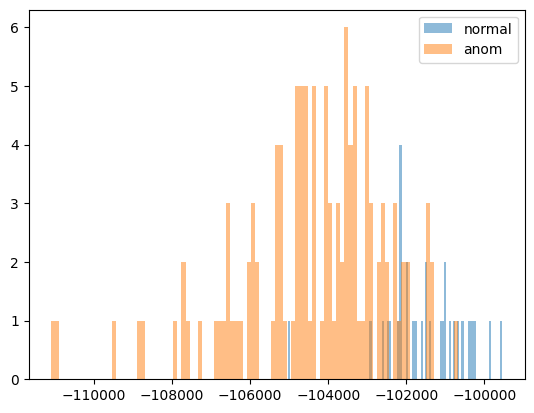

In [46]:
plt.hist(normal_lls, bins=100, alpha=0.5, label="normal")
plt.hist(anom_lls, bins=100, alpha=0.5, label="anom")
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
normal_lls = np.array(normal_lls) * -1
anom_lls = np.array(anom_lls) * -1
y_true = np.concatenate([np.zeros(len(normal_lls)), np.ones(len(anom_lls))])
y_score = np.concatenate([normal_lls, anom_lls])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

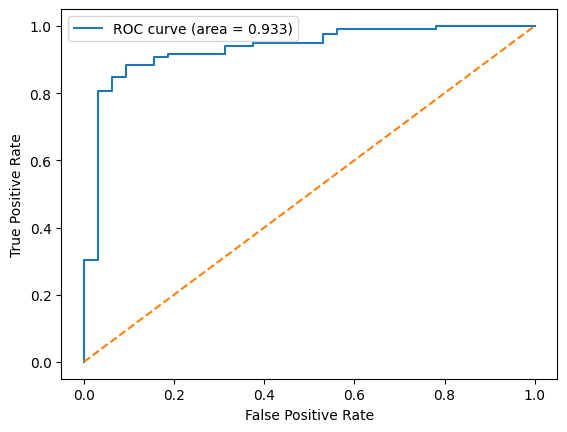

: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()